## SNAP proxy search for SNPs in LD with lead SNPs

1. Navigate to [SNAP Proxy Search](https://www.broadinstitute.org/mpg/snap/ldsearch.php)
+ Enter lead SNPs of interest under "Query SNPs"
+ Under "Search Options" set
  + SNP data set: 1000 Genomes Pilot 1
  + Population panel: CEU
  + r2 threshold: 0.5
  + Distance limit: 500
+ Under "Ouput Options"
  + Download to: File
  + Select "Include each query snp as a proxy for itself"
  + Select "Suppress warning messages in output"
+ Under "Filter By Array" make sure all are unselected
+ Under "Output Columns" select all besides "Associated Gene Annotations from GeneCruiser (decreases performance)"

In [1]:
import pandas
import numpy
import collections
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [2]:
# Window boundaries are determined as the furthest upstream and
# downstream SNPs with r-squared greater than or equal to this theshold 
r2_theshold = 0.5

In [3]:
# Read SNAP proxy search
path = 'data/snap/do-proxy-SNPs.tsv.gz'
snap_df = pandas.read_table(path, compression='gzip', na_values=['N/A'])
snap_df = snap_df.dropna(subset=['Coordinate_HG18'])
snap_df.Coordinate_HG18 = snap_df.Coordinate_HG18.astype(int)
snap_df.head()

,SNP,Proxy,Distance,RSquared,DPrime,Arrays,Chromosome,Coordinate_HG18,RecombinationRate,GeneticMapDistance,GeneticMapPosition,Major,Minor,MAF,NObserved
0,rs1000113,rs1000113,0,1,1,"AS,A5,A6,IM,IMD,IBC,OQ,AxM,CM,OE,E1,E11,O24,O2...",chr5,150220269,0.00522,0.00000,167.99774,C,T,0.042,120
1,rs1000113,rs11167515,605,1,1,"I2,I5,I6,I6Q,IM,IMD,AxM,IWQ,O54,O5E",chr5,150219664,0.00000,0.00040,167.99734,G,T,0.042,120
2,rs1000113,rs59980321,1737,1,1,None,chr5,150222006,0.00489,0.00001,167.99775,A,T,0.042,120
3,rs1000113,rs10078968,4197,1,1,AxM,chr5,150224466,0.00814,0.00002,167.99776,C,A,0.042,120
4,rs1000113,rs17727568,4612,1,1,None,chr5,150224881,0.00484,0.00002,167.99776,A,G,0.042,120


In [4]:
# Read SNAP proxy search input
path = 'data/snap/do-lead-SNPs.txt'
with open(path) as read_file:
    leads = {line.rstrip() for line in read_file}

print('Of {} lead SNPs, {} not found in SNAP'.format(len(leads), len(leads - set(snap_df.SNP))))

Of 5616 lead SNPs, 546 not found in SNAP


In [5]:
# Condense SNAP proxy search by lead SNP and compute windows
snap_errors = list()

rows = list()
for snp, group_df in snap_df.groupby('SNP', as_index=False):
    try:
        self_df = group_df[group_df.Proxy == snp]
        assert len(self_df) <= 1
        lead = self_df.iloc[0]
    except IndexError:
        snap_errors.append(snp)
        continue
    
    row = pandas.Series()
    row['lead_snp'] = snp
    row['lead_chrom'] = lead['Chromosome']
    row['lead_coord'] = lead['Coordinate_HG18']
    row['lead_maf'] = lead['MAF']
    
    window_df = group_df[(group_df.Chromosome == row['lead_chrom']) & (group_df.RSquared >= r2_theshold)]
    i_min = numpy.argmin(list(window_df.Coordinate_HG18))
    i_max = numpy.argmax(list(window_df.Coordinate_HG18))
    for side, i in ('lower', i_min), ('upper', i_max):
        window = window_df.iloc[i]
        row[side + '_snp'] = window.Proxy
        row[side + '_coord'] = window.Coordinate_HG18
        row[side + '_map_dist'] = window.GeneticMapDistance
        row[side + '_maf'] = window.MAF
    
    row['span_kb'] = (row['upper_coord'] - row['lower_coord']) / 1000
    row['span_cM'] = row['lower_map_dist'] + row['upper_map_dist']
    rows.append(row)

window_df = pandas.DataFrame(rows)
window_df.to_csv('data/snap/windows.tsv', index=False, sep='\t', float_format='%.5g')

# Number of lead SNPs that returned problematic SNAP proxies
len(snap_errors)

42

In [6]:
# See the head of window_df, containing window infornation for each lead SNP
window_df.head()

,lead_snp,lead_chrom,lead_coord,lead_maf,lower_snp,lower_coord,lower_map_dist,lower_maf,upper_snp,upper_coord,upper_map_dist,upper_maf,span_kb,span_cM
0,rs1000113,chr5,150220269,0.042,rs76767593,150150036,0.04616,0.042,rs73268545,150315475,0.02666,0.042,165.439,0.07282
1,rs1000579,chr4,4770395,0.442,rs7693647,4735225,0.03380,0.492,rs4689926,4784293,0.01430,0.383,49.068,0.04810
2,rs1000589,chr13,63039914,0.450,rs7989288,62902590,0.07185,0.400,rs35183012,63050456,0.00554,0.342,147.866,0.07739
3,rs1000597,chr7,30903703,0.100,rs12669187,30882003,0.03227,0.067,rs1000597,30903703,0.00000,0.100,21.700,0.03227
4,rs10007052,chr4,142225023,0.183,rs59849151,142221195,0.00287,0.108,rs10032239,142233594,0.01041,0.108,12.399,0.01328


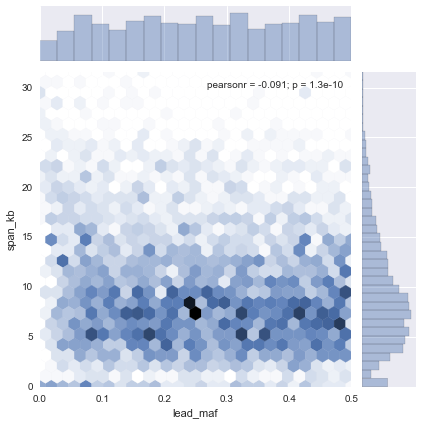

In [7]:
# View window span (kilobases) versus minor allele frequency
seaborn.jointplot(window_df.lead_maf, numpy.sqrt(window_df.span_kb), kind='hex');

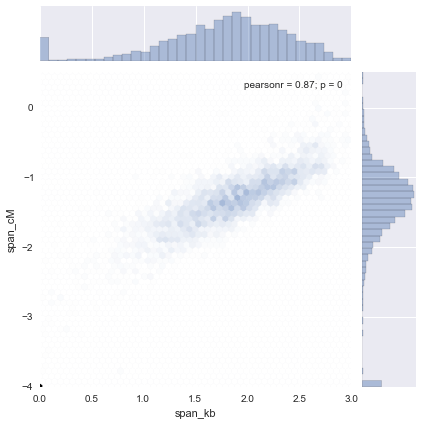

In [8]:
# View window span (kilobases) versus span (centimorgans)
seaborn.jointplot(numpy.log10(1 + window_df.span_kb), numpy.log10(0.0001 + window_df.span_cM), kind='hex');

In [9]:
# How many windows have span_kb of zero
sum(window_df.span_kb == 0)

160

In [10]:
# How many windows have span_kb of zero
sum(window_df.span_cM == 0)

162

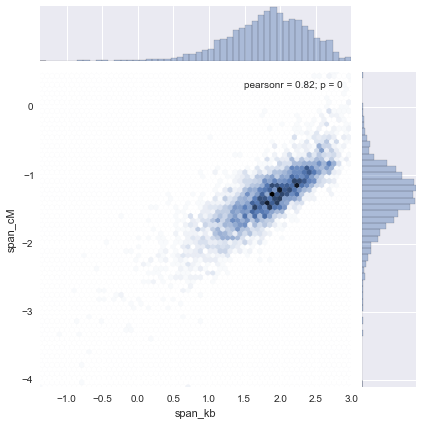

In [11]:
# Remove zero-span windows and view span (kilobases) versus span (centimorgans)
nonzero_df = window_df[(window_df.span_kb > 0) & (window_df.span_cM > 0)]
seaborn.jointplot(numpy.log10(nonzero_df.span_kb), numpy.log10(nonzero_df.span_cM), kind='hex');